In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                                     Embedding, Flatten, Input, Multiply, Reshape)
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [34]:
def sample_images(image_grid_rows=2, image_grid_columns=5, iteration=15000):
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
  labels = np.arange(0,10).reshape(-1,1)
  gen_imgs = generator.predict([z,labels])
  gen_imgs = 0.5 * gen_imgs + 0.5
  fix, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(10,4),
                          sharey=True,
                          sharex=True)
  
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].set_title(f"Digit: {labels[cnt]}")
      axs[i, j].axis('off')
      cnt += 1
  if iteration > 15000:
      plt.savefig(f"result_{iteration}.png")

In [9]:
img_shape = (28, 28, 1)
z_dim = 100
num_classes = 10

# 생성자

In [10]:
def build_generator(z_dim):
  model = Sequential([
                      Dense(256*7*7, input_dim=z_dim),
                      Reshape((7,7,256)),
                      # 7 x 7 x 256 >> 14 x 14 x 128
                      Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'),
                      BatchNormalization(),
                      LeakyReLU(alpha=0.2),
                      # 14 x 14 x 128 >> 14 x 14 x 64
                      Conv2DTranspose(64,kernel_size=3, strides=1, padding='same'),
                      BatchNormalization(),
                      LeakyReLU(alpha=0.02),
                      Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'),
                      Activation('tanh'), # 학습의 안정성을 높이고자 Batchnorm, leakyReLU, tanh 사용
  ])
  return model

In [11]:
def build_cgan_generator(z_dim):

  z = Input(shape=(z_dim, ))
  label = Input(shape=(1, ), dtype='int32')

  label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)
  label_embedding = Flatten()(label_embedding) 

  joined_representation = Multiply()([z, label_embedding])
  generator = build_generator(z_dim)
  conditioned_img = generator(joined_representation) # 주어진 레이블에 대한 이미지 생성
  return Model([z, label], conditioned_img)

# 판별자

In [12]:
def build_discriminator(img_shape):
  model = Sequential([
         # 28 x 28 x 2 >> 14 x 14 x 64             
         Conv2D(64, kernel_size=3, strides=2, input_shape=(img_shape[0], img_shape[1], img_shape[2]+1), padding='same'),
         LeakyReLU(alpha=0.2),
         # 14 x 14 x 64 >> 7 x 7 x 64
         Conv2D(64, kernel_size=3, strides=2, padding='same'),
         LeakyReLU(alpha=0.2),
         Conv2D(128, kernel_size=3, strides=2, padding='same'),
         LeakyReLU(alpha=0.2),
         Flatten(),
         Dense(1, activation='sigmoid'),
  ])
  return model

In [13]:
def build_cgan_discriminator(img_shape):
  img = Input(shape=img_shape)
  label = Input(shape=(1, ), dtype='int32')
  label_embedding = Embedding(num_classes, np.prod(img_shape), input_length=1)(label) #output dim: np.prod(img_shape)
  label_embedding = Flatten()(label_embedding)
  label_embedding = Reshape(img_shape)(label_embedding)
  concatenated = Concatenate(axis=-1)([img, label_embedding])
  discriminator = build_discriminator(img_shape)
  classification = discriminator(concatenated)
  return Model([img, label], classification)

In [14]:
def build_cgan(generator, discriminator):
  z = Input(shape=(z_dim, ))
  label = Input(shape=(1, ))
  img = generator([z, label])
  classification = discriminator([img, label])
  model = Model([z,label], classification)
  return model

In [15]:
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])
generator = build_cgan_generator(z_dim)
discriminator.trainable = False
cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

In [27]:
accuracies = []
losses = []

def train(iterations, batch_size, sample_interval):
  (X_train, y_train), (_, _) = mnist.load_data()

  X_train = X_train / 127.5 - 1
  X_train = X_train[... , np.newaxis]

  real = np.ones((batch_size, 1))

  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):

    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx]

    z = np.random.normal(0,1, (batch_size, z_dim)) # 가짜 이미지 배치를 생성
    gen_imgs = generator.predict([z, labels])

    d_loss_real = discriminator.train_on_batch([imgs, labels], real)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    z = np.random.normal(0,1, (batch_size, z_dim))

    labels = np.random.randint(0, num_classes, batch_size).reshape(-1,1)
    g_loss = cgan.train_on_batch([z,labels], real)

    if (iteration + 1) % sample_interval == 0:
      print(f'Epoch | {iteration+1} D loss | {d_loss[0]} D acc | {d_loss[1]*100} | G loss {g_loss}')
      losses.append((d_loss[0], g_loss))
      accuracies.append(100 * d_loss[1])
      sample_images(iteration=iteration)

Epoch | 1000 D loss | 0.6921875476837158 D acc | 34.375 | G loss 0.680815577507019
Epoch | 2000 D loss | 0.7011508643627167 D acc | 34.375 | G loss 0.6706150770187378
Epoch | 3000 D loss | 0.7467032670974731 D acc | 40.625 | G loss 0.5711761116981506
Epoch | 4000 D loss | 0.7240815758705139 D acc | 29.6875 | G loss 0.6162811517715454
Epoch | 5000 D loss | 0.6916637122631073 D acc | 42.1875 | G loss 0.6778943538665771
Epoch | 6000 D loss | 0.6740679442882538 D acc | 71.875 | G loss 0.740472674369812
Epoch | 7000 D loss | 0.6928970217704773 D acc | 43.75 | G loss 0.6644496917724609
Epoch | 8000 D loss | 0.676880270242691 D acc | 75.0 | G loss 0.7222523093223572
Epoch | 9000 D loss | 0.6450525224208832 D acc | 89.0625 | G loss 0.7636833190917969
Epoch | 10000 D loss | 0.709477037191391 D acc | 25.0 | G loss 0.6633418202400208
Epoch | 11000 D loss | 0.7216121256351471 D acc | 23.4375 | G loss 0.6686887741088867
Epoch | 12000 D loss | 0.5671294182538986 D acc | 92.1875 | G loss 0.9309448003

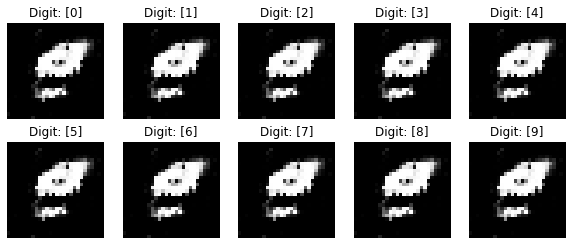

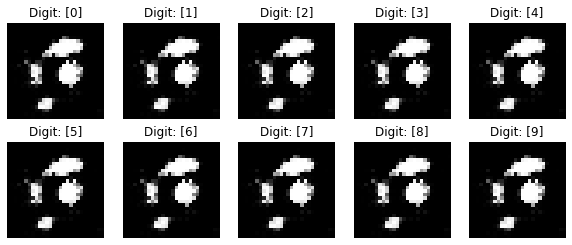

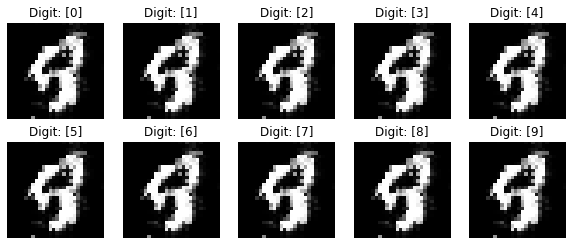

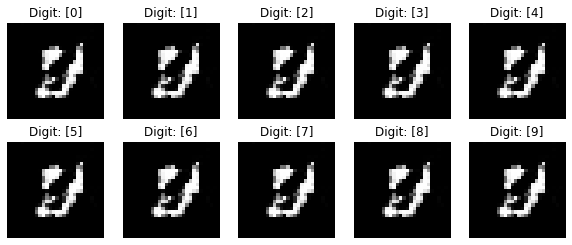

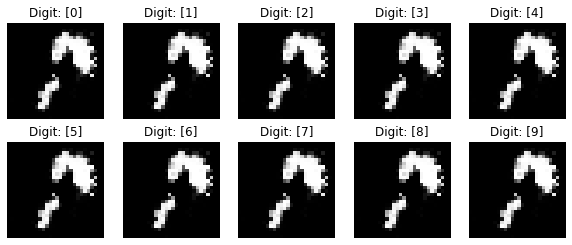

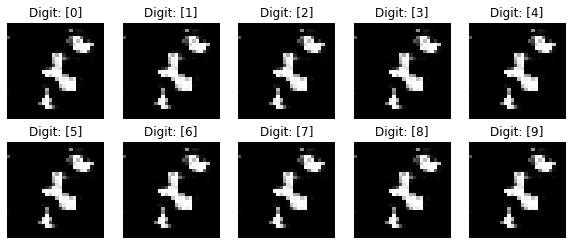

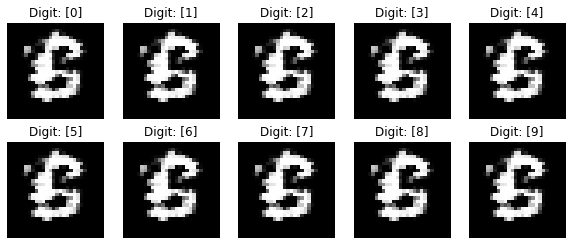

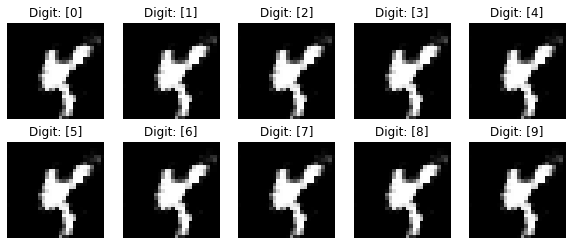

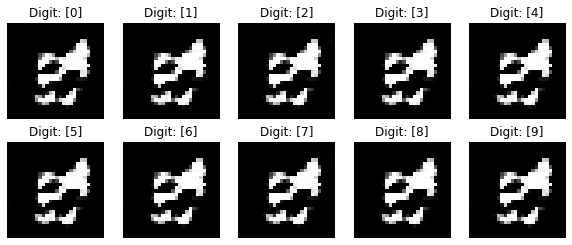

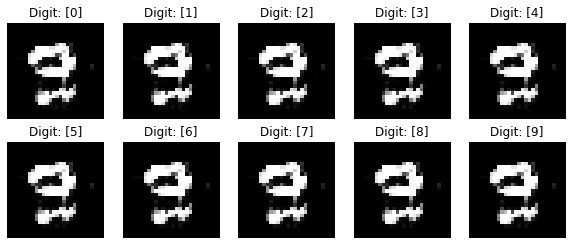

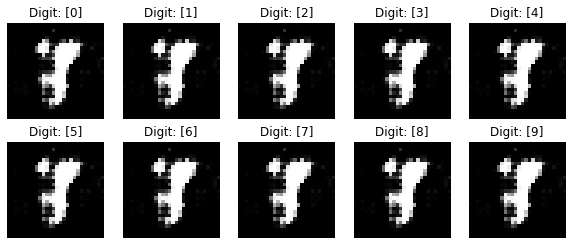

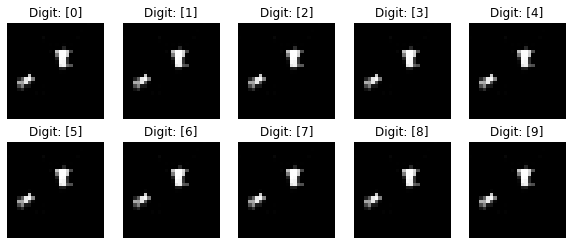

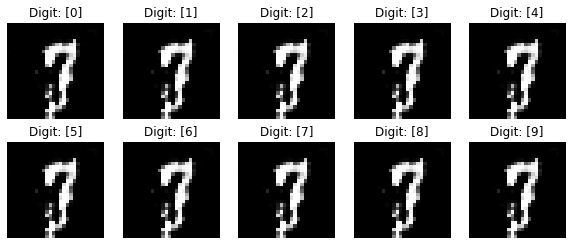

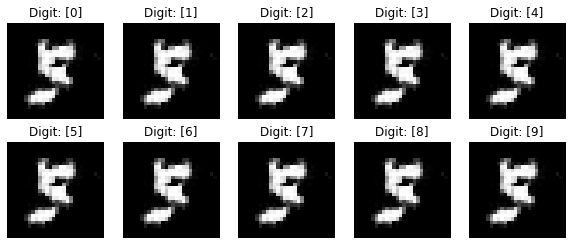

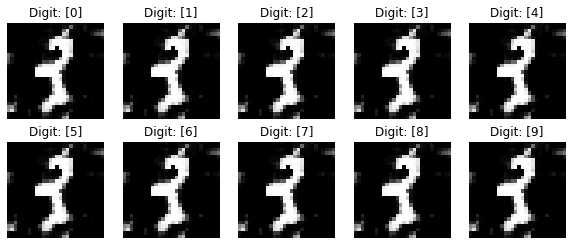

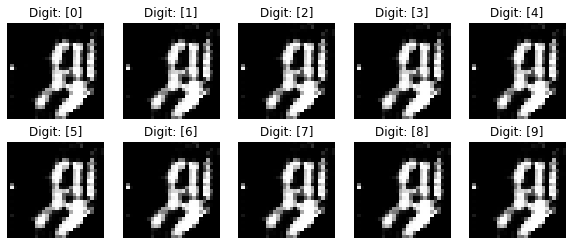

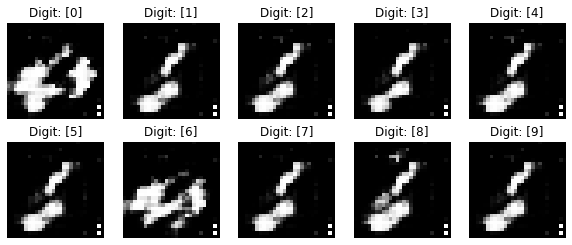

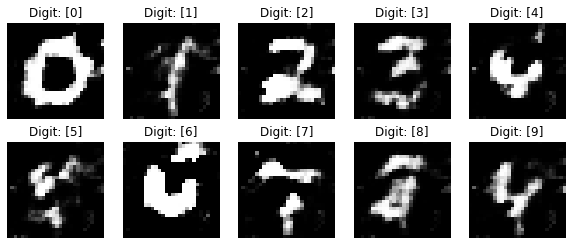

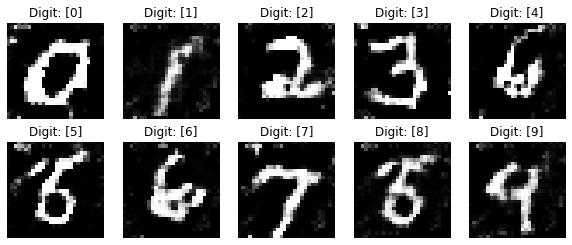

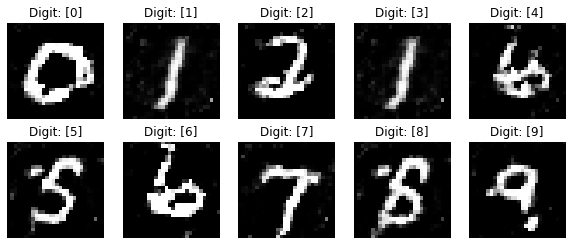

In [35]:
iterations = 20000
batch_size = 32
sample_interval = 1000
train(iterations, batch_size, sample_interval)